In [24]:
import pickle as pkl
import pandas as pd
import numpy as np
import os
import json
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import random
import pickle
import nltk
from collections import Counter
sns.set_palette("colorblind")
from matplotlib.gridspec import GridSpec

In [3]:
# plot and font settings
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none' # Use text for text in SVG

In [4]:
label_dict = {"congress": "Congress",
            "fiction": "Fiction",
            "nyt": "New York Times",
            "caselaw": "Case Law",
            "movie": "Movie",
            "total": "Total"}

# Overall Trend

In [8]:
data_path = "/zfs/projects/faculty/amirgo-management/code_review_data/pooling/"
df = pd.read_csv(data_path + "implicit_trend.csv")
df = df.loc[(df['year'] >=1950) & (df['year'] <= 2017)]

/tmp/ipykernel_1419053/1376803329.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path + "implicit_trend.csv")


In [9]:
def get_plot_data(fig):
    ax = fig.axes[0] # access the first and only axis
    # ax = fig.axes
    x_data = ax.lines[0].get_xdata()
    y_data = ax.axes.lines[0].get_ydata()
    confidence_dict = {}
    for i in range(len(x_data)):
        confidence_dict[x_data[i]] = []

    # confidence interval
    confidence_shape = ax.collections[0].get_paths()[0].vertices
    for i in range(len(confidence_shape)):
        year = confidence_shape[i][0]
        value = confidence_shape[i][1]
        if value not in confidence_dict[year]:
            confidence_dict[year].append(value)
    # sort the confidence interval
    for year in confidence_dict:
        confidence_dict[year].sort()
        
    # covert to a single df
    x_data = x_data.tolist()
    y_data = y_data.tolist()
    ci_lower = [confidence_dict[x_data[i]][0] for i in range(len(x_data))]
    ci_upper = [confidence_dict[x_data[i]][1] for i in range(len(x_data))]
    plot_df = pd.DataFrame({'year': x_data, 'y': y_data, 'ci_lower': ci_lower, 'ci_upper': ci_upper})

    # add smoothed data
    plot_df['y_smooth'] = plot_df['y'].rolling(window=10, min_periods=1).mean()
    plot_df['ci_lower_smooth'] = plot_df['ci_lower'].rolling(window=10, min_periods=1).mean()
    plot_df['ci_upper_smooth'] = plot_df['ci_upper'].rolling(window=10, min_periods=1).mean()

    # normalize the data
    y_min = min(plot_df['y_smooth'])
    y_max = max(plot_df['y_smooth'])
    plot_df['y_norm'] = (plot_df['y_smooth'] - y_min) / (y_max - y_min)
    plot_df['ci_lower_norm'] = (plot_df['ci_lower_smooth'] - y_min) / (y_max - y_min)
    plot_df['ci_upper_norm'] = (plot_df['ci_upper_smooth'] - y_min) / (y_max - y_min)
    
    return plot_df

In [ ]:
plot_dfs = []
datasets = list(df['dataset'].unique())
datasets.append('total')

for dataset in tqdm(datasets):
    print("Processing dataset: ", dataset)
    if dataset != 'total':
        df_dataset = df[df['dataset'] == dataset].copy()
    else:
        df_dataset = df.copy()

    # normalize the data
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.lineplot(x='year', y='subgroup_orig_syn_ratio', data=df_dataset, ax=ax)

    plot_df = get_plot_data(fig)
    plot_df['dataset'] = dataset
    plot_dfs.append(plot_df)

    plt.close(fig)

total_plot_df = pd.concat(plot_dfs)
total_plot_df.to_csv(data_path+'implicit_pooling_plot.csv', index=False)

In [8]:
# no legend version
# predetermine the color for each dataset
color_dict = {
    'fiction': '#0173b2',
    'nyt': '#de8f05',
    'caselaw': '#029e73',
    'congress': '#d55e00',
    'movie': '#cc78bc',
    'total': '#ca9161'
}

def plot_implicit_trend_nolegend(total_plot_df):
    datasets = ['fiction','nyt','caselaw','congress','movie','total'] # a fixed sequence
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    for dataset in datasets:
        df_dataset = total_plot_df[total_plot_df['dataset'] == dataset]
        # color blind palette
        color = color_dict[dataset]
        if dataset == 'total':
            ax.plot(df_dataset['year'], df_dataset['y_norm'], label=label_dict[dataset], color=color, linewidth=4)
            ax.fill_between(df_dataset['year'], df_dataset['ci_lower_norm'], df_dataset['ci_upper_norm'], alpha=0.7)
        else:
            ax.plot(df_dataset['year'], df_dataset['y_norm'], label=label_dict[dataset], color=color, alpha=0.7)
            ax.fill_between(df_dataset['year'], df_dataset['ci_lower_norm'], df_dataset['ci_upper_norm'], alpha=0.3)

    ax.set_xlabel('Year', fontsize=20)
    ax.set_ylabel('Normalized Metaphor Score', fontsize=20)
    ax.tick_params(axis='both', labelsize=18)
    # Make plot "half open"
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # less tick labels
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))

    plt.show()
    return fig

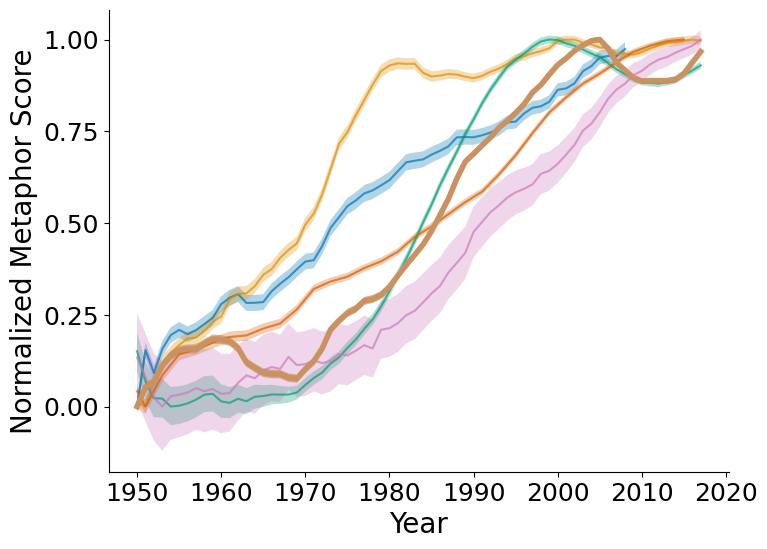

In [ ]:
data_path = "/zfs/projects/faculty/amirgo-management/code_review_data/figure/"
total_plot_df = pd.read_csv(data_path+'implicit_pooling_plot.csv')
total_plot_df = total_plot_df[~((total_plot_df['dataset'] == 'fiction') & (total_plot_df['year'] >= 2009))]
fig = plot_implicit_trend_nolegend(total_plot_df)
fig.savefig(data_path+'implicit_plot_nolegend.svg', format='svg', bbox_inches='tight', dpi=300, transparent=True)

# Trend by Domain

In [10]:
# load category map for object categories
with open('/zfs/projects/faculty/amirgo-management/code_review/3_feature_generation/implicit/fillmask_target_objects.json') as f:
    category_map = json.load(f)
category_map['lemmatized'].keys()

dict_keys(['subjectivity', 'body', 'relationship', 'relational_subjectivity'])

In [ ]:
def gen_group_category(df, category_map):
    # category_map: dictionary key --> list of objects
    # check primary object category: subjectivity, relationship, body
    subjectivity_words = category_map['lemmatized']['subjectivity']
    relationship_words = category_map['lemmatized']['relationship']
    body_words = category_map['lemmatized']['body']

    # for each object in each row, find the corresponding category
    df['object_category'] = df['object'].progress_apply(lambda x: 'subjectivity' if x in subjectivity_words else ('relationship' if x in relationship_words else ('body' if x in body_words else 'NAN')))

    # check relational subjectivity, a standalone category
    relational_subjectivity_words = category_map['lemmatized']['relational_subjectivity']
    df['if_relational_subjectivity'] = df.apply(lambda x: 1 if x['object'] in relational_subjectivity_words else 0, axis=1)
    return df

# plot individual datasets and save the plot df
def plot_df_per_ds(df, dataset):
    plot_dfs = []
    if dataset != 'total':
        df = df[df['dataset'] == dataset]
    obj_categories = list(df['object_category'].unique())
    obj_categories = [x for x in obj_categories if x != 'NAN']
    for cat in tqdm(obj_categories):
        print("Processing object category: ", cat)
        df_dataset = df[df['object_category'] == cat].copy()
        # normalize the data
        fig, ax = plt.subplots(figsize=(5, 4))
        sns.lineplot(x='year', y='subgroup_orig_syn_ratio', data=df_dataset, ax=ax)
        plot_df = get_plot_data(fig)
        plot_df['category'] = cat
        plot_dfs.append(plot_df)
        plt.close(fig)
    total_plot_df = pd.concat(plot_dfs)
    return total_plot_df

# plot aggregated dataset and save the plot df
def plot_df_total_ds(df):
    # for each dataset adjust the scores using standardization
    df_ls = []
    datasets = list(df['dataset'].unique())
    categories = list(df['object_category'].unique())
    categories = [x for x in categories if x != 'NAN']
    for dataset in tqdm(datasets):
        df_dataset = df[df['dataset'] == dataset].copy()
        # adjust the mean and std for each dataset
        df_dataset['subgroup_orig_syn_ratio'] = (df_dataset['subgroup_orig_syn_ratio'] - df_dataset['subgroup_orig_syn_ratio'].mean()) / df_dataset['subgroup_orig_syn_ratio'].std()
        df_ls.append(df_dataset)
    total_df = pd.concat(df_ls, ignore_index=True)

    # now plot the data
    plot_dfs = []
    for cat in tqdm(categories):
        print("Processing object category: ", cat)
        fig, ax = plt.subplots(figsize=(5, 4))
        df_category = total_df[total_df['object_category'] == cat]
        sns.lineplot(x='year', y='subgroup_orig_syn_ratio', data=df_category, ax=ax)
        plot_df = get_plot_data(fig)
        plot_df['category'] = cat
        plot_dfs.append(plot_df)
    total_plot_df = pd.concat(plot_dfs, ignore_index=True)
    return total_plot_df

In [12]:
df = gen_group_category(df, category_map)

# dataset specific plots
plot_dfs_by_ds = []
datasets = list(df['dataset'].unique())
for dataset in datasets:
    print("Processing dataset: ", dataset)
    plot_df = plot_df_per_ds(df, dataset)
    plot_df['dataset'] = dataset
    plot_dfs_by_ds.append(plot_df)

100%|██████████| 91157985/91157985 [01:15<00:00, 1199573.61it/s]


Processing dataset:  congress


  0%|          | 0/3 [00:00<?, ?it/s]

Processing object category:  relationship


 33%|███▎      | 1/3 [00:11<00:23, 11.92s/it]

Processing object category:  subjectivity


 67%|██████▋   | 2/3 [00:18<00:08,  8.67s/it]

Processing object category:  body


100%|██████████| 3/3 [00:22<00:00,  7.60s/it]


Processing dataset:  movie


  0%|          | 0/3 [00:00<?, ?it/s]

Processing object category:  relationship


 33%|███▎      | 1/3 [00:09<00:19,  9.82s/it]

Processing object category:  body


 67%|██████▋   | 2/3 [00:11<00:04,  4.75s/it]

Processing object category:  subjectivity


100%|██████████| 3/3 [00:13<00:00,  4.64s/it]


Processing dataset:  caselaw


  0%|          | 0/3 [00:00<?, ?it/s]

Processing object category:  relationship


 33%|███▎      | 1/3 [01:33<03:07, 93.89s/it]

Processing object category:  subjectivity


 67%|██████▋   | 2/3 [02:11<01:01, 61.04s/it]

Processing object category:  body


100%|██████████| 3/3 [02:27<00:00, 49.28s/it]


Processing dataset:  nyt


  0%|          | 0/3 [00:00<?, ?it/s]

Processing object category:  relationship


 33%|███▎      | 1/3 [01:43<03:26, 103.37s/it]

Processing object category:  subjectivity


 67%|██████▋   | 2/3 [02:19<01:03, 63.61s/it] 

Processing object category:  body


100%|██████████| 3/3 [02:37<00:00, 52.52s/it]


Processing dataset:  fiction


  0%|          | 0/3 [00:00<?, ?it/s]

Processing object category:  relationship


 33%|███▎      | 1/3 [02:03<04:07, 123.75s/it]

Processing object category:  subjectivity


 67%|██████▋   | 2/3 [02:51<01:19, 79.04s/it] 

Processing object category:  body


100%|██████████| 3/3 [02:58<00:00, 59.57s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

Processing object category:  relationship


 33%|███▎      | 1/3 [07:54<15:49, 474.77s/it]

Processing object category:  subjectivity


 67%|██████▋   | 2/3 [10:53<05:00, 300.74s/it]

Processing object category:  body


100%|██████████| 3/3 [11:40<00:00, 233.66s/it]


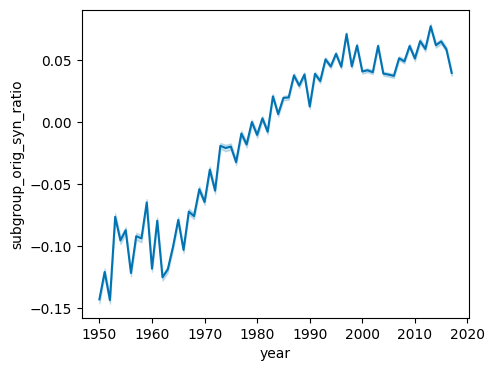

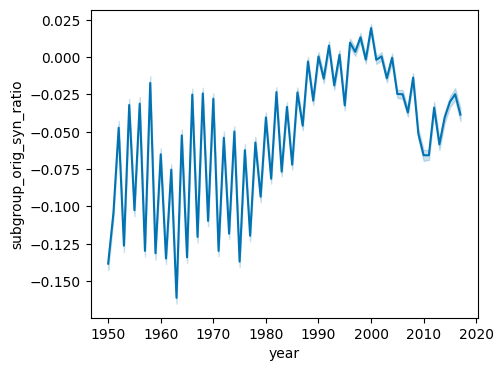

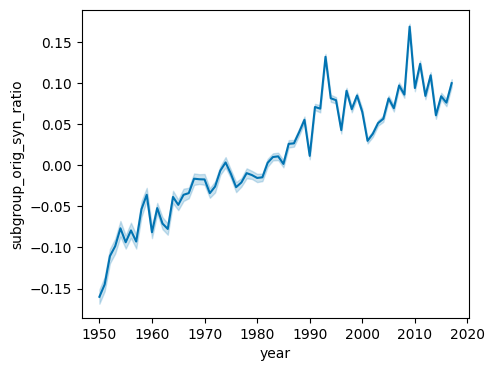

In [ ]:
# aggregation plots
aggregated_plot_df = plot_df_total_ds(df)
aggregated_plot_df['dataset'] = 'total'
plot_dfs_by_ds.append(aggregated_plot_df)
total_plot_df['year'] = total_plot_df['year'].astype(int)
total_plot_df = pd.concat(plot_dfs_by_ds, ignore_index=True)
total_plot_df.to_csv(data_path+'implicit_pooling_plot_by_category_v2.csv', index=False)

In [78]:
def plot_square_layout(total_plot_df):
    total_plot_df = total_plot_df[total_plot_df['year'] <= 2017]
    categories = ['subjectivity', 'body', 'relationship']
    datasets = ['nyt', 'caselaw', 'congress', 'movie', 'fiction', 'total']

    # Set up color map
    category_colors = sns.color_palette("colorblind", len(categories))
    category_color_map = dict(zip(categories, category_colors))

    # Set up 3x3 grid
    fig = plt.figure(figsize=(9, 9))
    gs = GridSpec(3, 3, figure=fig, wspace=0.3, hspace=0.3)

    # --- Main plot (total), spans 2x2 area ---
    main_ax = fig.add_subplot(gs[0:2, 0:2])
    df_total = total_plot_df[total_plot_df['dataset'] == 'total']
    for cat in categories:
        df_cat = df_total[df_total['category'] == cat]
        color = category_color_map[cat]
        main_ax.plot(df_cat['year'], df_cat['y_smooth'], label=cat, color=color, alpha=0.8)
        main_ax.fill_between(df_cat['year'], df_cat['ci_lower_smooth'], df_cat['ci_upper_smooth'], color=color, alpha=0.3)

    main_ax.set_title(label_dict['total'], fontsize=18)
    main_ax.set_ylabel("Implicit Metaphor Score (Standardized)", fontsize=14)
    main_ax.set_xlabel("")
    main_ax.tick_params(labelsize=12)
    main_ax.spines['top'].set_visible(False)
    main_ax.spines['right'].set_visible(False)
    main_ax.axvline(x=1980, color='gray', linestyle='--', linewidth=0.8)

    # Legend inside the main plot
    handles = [plt.Line2D([0], [0], color=category_color_map[cat], lw=2) for cat in categories]
    main_ax.legend(handles, categories, 
                   title="Category", loc='upper left', fontsize=12, title_fontsize=14, frameon=False)

    # --- Subplots for other datasets ---
    positions = [(0, 2), (1, 2), (2, 0), (2, 1), (2, 2)]
    for i, dataset in enumerate(datasets[:-1]):
        row, col = positions[i]
        ax = fig.add_subplot(gs[row, col])
        df_ds = total_plot_df[total_plot_df['dataset'] == dataset]

        for cat in categories:
            df_cat = df_ds[df_ds['category'] == cat]
            color = category_color_map[cat]
            ax.plot(df_cat['year'], df_cat['y_smooth_exp'], label=cat, color=color, alpha=0.8)
            ax.fill_between(df_cat['year'], df_cat['ci_lower_smooth_exp'], df_cat['ci_upper_smooth_exp'], color=color, alpha=0.3)

        ax.set_title(label_dict[dataset], fontsize=12)
        ax.tick_params(axis='y', labelsize=10)
        ax.set_xlabel("")
        if i==2:
            ax.set_ylabel("Implicit Metaphor Score (Exp.)", fontsize=12)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.axvline(x=1980, color='gray', linestyle='--', linewidth=0.8)
        # set y-ticks to have 2 decimal places
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))

    return fig

In [70]:
data_path = "/zfs/projects/faculty/amirgo-management/code_review_data/figure/"
total_plot_df=pd.read_csv(data_path+'implicit_pooling_plot_by_category_v2.csv')
total_plot_df = total_plot_df[~((total_plot_df['dataset'] == 'fiction') & (total_plot_df['year'] >= 2009))]

# exponentiate the scores
total_plot_df['y_smooth_exp'] = np.exp(total_plot_df['y_smooth'])
total_plot_df['ci_lower_smooth_exp'] = np.exp(total_plot_df['ci_lower_smooth'])
total_plot_df['ci_upper_smooth_exp'] = np.exp(total_plot_df['ci_upper_smooth'])

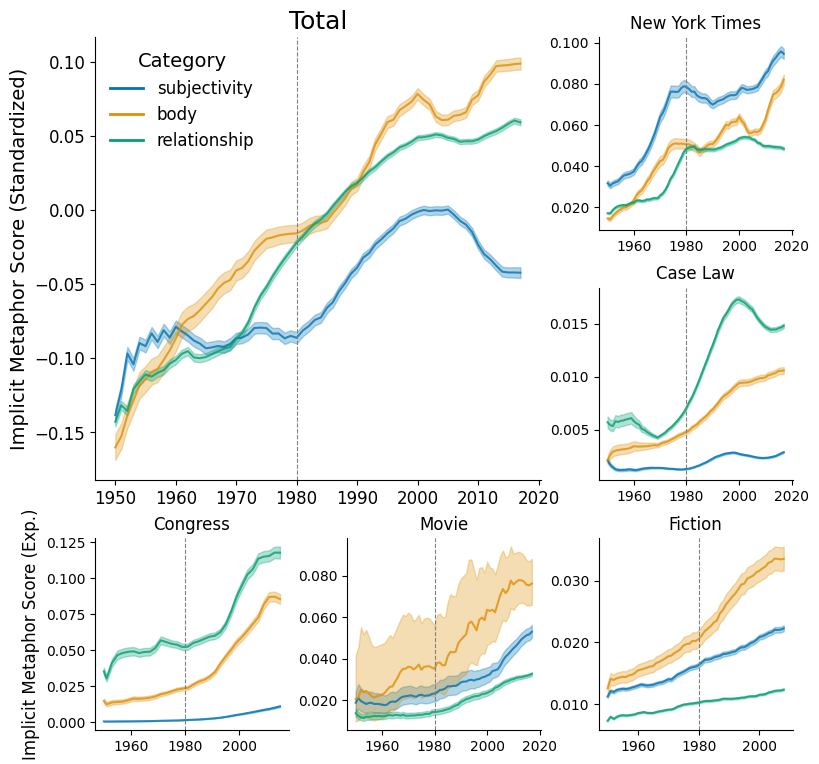

In [79]:
# cut after 2009 for fiction ds
fig = plot_square_layout(total_plot_df)

In [80]:
# save the figure
fig.savefig(data_path+'implicit_domain_nolegend.svg', format='svg', bbox_inches='tight', dpi=300, transparent=True)